<a href="https://colab.research.google.com/github/Saravanakumar2005/Cognorise-Infotech/blob/main/diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn import svm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report


READ DATASET

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Classroom/diabetes_prediction_dataset.csv')

In [ ]:
df.sample(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
57300,Male,61.0,0,0,No Info,36.81,4.5,200,0
60757,Female,48.0,0,0,former,35.53,4.5,155,0
2407,Female,47.0,0,0,No Info,27.32,4.5,85,0
20698,Male,19.0,0,0,never,26.00,5.8,145,0
40744,Female,22.0,0,0,No Info,27.43,3.5,158,0


Gender is not necessary lets drop it

In [ ]:
df = df.drop('gender', axis=1)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  100000 non-null  float64
 1   hypertension         100000 non-null  int64  
 2   heart_disease        100000 non-null  int64  
 3   smoking_history      100000 non-null  object 
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 6.1+ MB
None


*Check* duplicates

In [ ]:
df.duplicated().sum()

6389

In [ ]:
df = df.drop_duplicates()
df.shape[0]

93611

In [ ]:
df.replace('No Info', float('nan'), inplace=True)

<ipython-input-7-f6644e537d4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('No Info', float('nan'), inplace=True)


Correlation Matrix

<ipython-input-10-6bc8b84bf88e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, cmap = 'RdPu')


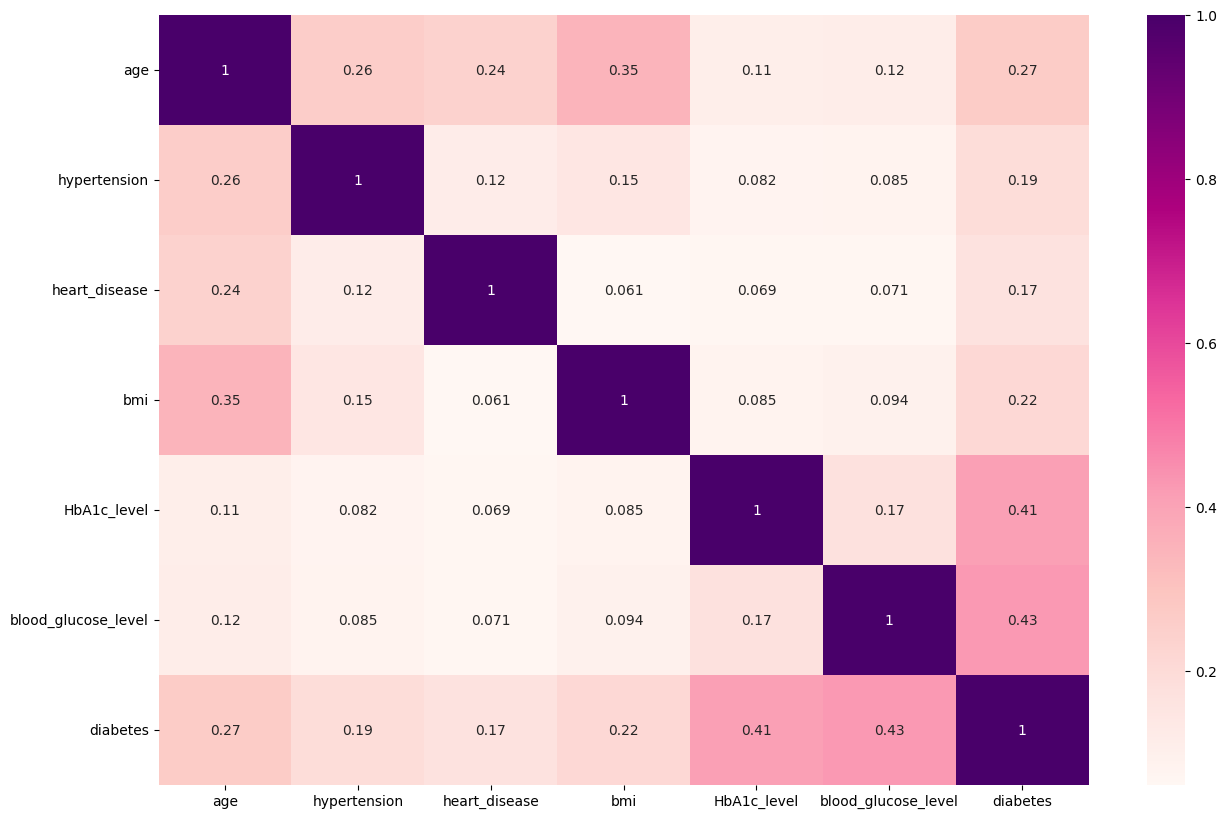

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot = True, cmap = 'RdPu')
plt.show()

In [ ]:
print(df.columns)

Index(['age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi',
       'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


Data Visualization

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

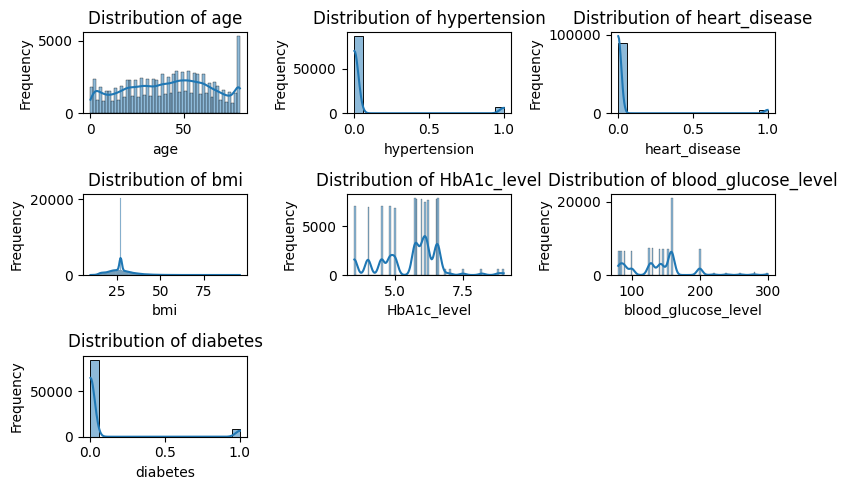

In [ ]:
# Distribution plots for each numeric feature
plt.figure(figsize=(8, 5))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


One hot encoding

In [ ]:
print(df['smoking_history'].unique())

['never' nan 'current' 'former' 'ever' 'not current']


In [ ]:
categorical_cols = ['smoking_history']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


Check for missing values

In [ ]:
df.isnull().sum()

age                            0
hypertension                   0
heart_disease                  0
bmi                            0
HbA1c_level                    0
blood_glucose_level            0
diabetes                       0
smoking_history_ever           0
smoking_history_former         0
smoking_history_never          0
smoking_history_not current    0
dtype: int64

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,93611.0,41.833746,22.485157,0.08,24.00,43.00,60.000,80.00
hypertension,93611.0,0.079606,0.270684,0.00,0.00,0.00,0.000,1.00
heart_disease,93611.0,0.041747,0.200012,0.00,0.00,0.00,0.000,1.00
bmi,93611.0,27.322993,6.857632,10.01,23.24,27.32,30.035,95.69
HbA1c_level,93611.0,5.536296,1.075454,3.50,4.80,5.80,6.200,9.00
blood_glucose_level,93611.0,138.331670,41.052424,80.00,100.00,140.00,159.000,300.00
diabetes,93611.0,0.090481,0.286871,0.00,0.00,0.00,0.000,1.00
smoking_history_ever,93611.0,0.042634,0.202031,0.00,0.00,0.00,0.000,1.00
smoking_history_former,93611.0,0.098824,0.298427,0.00,0.00,0.00,0.000,1.00
smoking_history_never,93611.0,0.362116,0.480615,0.00,0.00,0.00,1.000,1.00


Check for Class Imbalance and sampling

In [ ]:
x = df.drop('diabetes', axis=1)
y = df['diabetes']

In [ ]:
target_distribution = y.value_counts(normalize=True) * 100

# Print the percentage distribution
target_distribution

0    90.951918
1     9.048082
Name: diabetes, dtype: float64

In [ ]:
# Assuming 'diabetes' is the target column
target_frequency = df['diabetes'].value_counts()

print(target_frequency)


0    85141
1     8470
Name: diabetes, dtype: int64


Handling imbalance dataset by applying SMOTE

In [ ]:
# by applying SMOTE

from imblearn.over_sampling import SMOTE

# Example: Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

In [ ]:
target_distribution = y_resampled.value_counts(normalize=True) * 100

# Print the percentage distribution
target_distribution

0    50.0
1    50.0
Name: diabetes, dtype: float64

Removing Outlier using Z-score

In [ ]:
X_resampled.sample(5)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
43918,80.0,1,0,21.530000,6.100000,90,0,0,1,0
72505,76.0,1,0,27.320000,5.800000,159,0,0,1,0
90039,40.0,0,0,34.170000,6.500000,85,1,0,0,0
73479,40.0,0,0,31.460000,6.200000,145,0,0,1,0
164832,80.0,0,0,27.536041,6.549915,300,0,0,0,0


In [ ]:
df = pd.concat([X_resampled, y_resampled], axis=1)


In [ ]:
numerical_cols = ['age','bmi','HbA1c_level','blood_glucose_level']

z_scores = zscore(df[numerical_cols])

# Set a threshold for outlier detection (e.g., 3 standard deviations)
threshold = 4

# Identify and remove outliers
outliers_mask = (abs(z_scores) > threshold).any(axis=1)
df = df[~outliers_mask]
row=df.shape[0]
print(row)
df=df.dropna()
row=df.shape[0]
row

169817


169817

Feature engineering

  Feature selection using Extra Trees Classifier

In [ ]:
df.sample(10)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,diabetes
148202,78.0,0,0,27.213989,8.8,280,0,0,0,0,1
89642,7.0,0,0,15.340000,6.0,130,0,0,0,0,0
31619,60.0,0,0,27.600000,4.8,90,0,0,1,0,0
28784,44.0,0,0,24.080000,4.8,126,0,0,0,0,0
89498,39.0,0,0,36.420000,5.8,85,0,0,1,0,0
8302,26.0,0,0,27.320000,6.5,160,0,1,0,0,0
38959,36.0,0,0,27.320000,6.2,159,0,0,0,0,0
80531,25.0,0,0,27.320000,6.2,155,0,0,0,0,0
41406,27.0,0,0,48.710000,4.0,140,0,0,0,0,0
29307,65.0,0,0,27.320000,6.2,100,0,0,1,0,0


In [ ]:
X_resampled = df.drop('diabetes', axis=1)
y_resampled = df['diabetes']

age                            0.211087
hypertension                   0.003489
heart_disease                  0.002320
bmi                            0.103467
HbA1c_level                    0.363017
blood_glucose_level            0.273828
smoking_history_ever           0.007888
smoking_history_former         0.007652
smoking_history_never          0.015276
smoking_history_not current    0.011976
dtype: float64


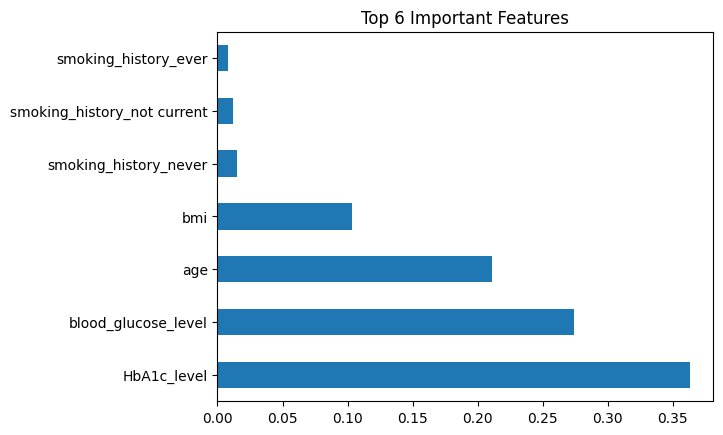

In [ ]:
# Feature Selection using Extra Trees Classifier
model = ExtraTreesClassifier()
model.fit(X_resampled, y_resampled)

# Display feature importances
feature_importances = pd.Series(model.feature_importances_, index=X_resampled.columns)
print(feature_importances)
feature_importances.nlargest(7).plot(kind='barh')
plt.title('Top 7 Important Features')
plt.show()

Slipt Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Training Models

Decision Tree

In [ ]:
start_time = time.time()
# Best Parameters for Decision Tree Classifier
best_params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

# Create and train the Decision Tree Classifier with the specified parameters
dt_classifier = DecisionTreeClassifier(criterion=best_params['criterion'],
                                       max_depth=best_params['max_depth'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       min_samples_split=best_params['min_samples_split'],
                                       random_state=0)

dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_classifier.predict(X_test)

training_time = time.time() - start_time


# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Model Accuracy:", accuracy_dt)
print("Decision Tree Classification Report:\n", report_dt)
print("training time:", training_time,"seconds")

Decision Tree Model Accuracy: 0.9715875633023201
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     16917
           1       0.98      0.97      0.97     17047

    accuracy                           0.97     33964
   macro avg       0.97      0.97      0.97     33964
weighted avg       0.97      0.97      0.97     33964

training time: 1.146697759628296 seconds


Random forest classifier

In [ ]:
start_time = time.time()
# Create and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=0, max_features='sqrt', n_estimators=100, max_depth=10)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

training_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)
print("training time:", training_time,"seconds")


Model Accuracy: 0.9290130726651749
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     16917
           1       0.92      0.94      0.93     17047

    accuracy                           0.93     33964
   macro avg       0.93      0.93      0.93     33964
weighted avg       0.93      0.93      0.93     33964

training time: 10.522815942764282 seconds


Catboost classifier

In [ ]:
start_time = time.time()

# Create the CatBoost Classifier
catboost_classifier = CatBoostClassifier(random_seed=42, logging_level='Silent', learning_rate=0.1, depth=10,subsample=0.8)

catboost_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = catboost_classifier.predict(X_test)

training_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("CatBoost Model Accuracy:", accuracy)
print("Classification Report:\n", report)
print("training time:", training_time,"seconds")


CatBoost Model Accuracy: 0.9801849016605818
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     16917
           1       0.99      0.97      0.98     17047

    accuracy                           0.98     33964
   macro avg       0.98      0.98      0.98     33964
weighted avg       0.98      0.98      0.98     33964

training time: 50.27085781097412 seconds


XG Boost

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def XGboost():
    start_time = time.time()

    xgb = XGBClassifier(objective='binary:logistic', learning_rate=0.2, n_estimators=250, max_depth=3, subsample=1,
                        colsample_bytree=1, gamma=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42)

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)

    training_time = time.time() - start_time

    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    report = classification_report(y_test, y_pred)

    print('XGBoost Classifier Test Score: \n', accuracy)
    print('Classification Report:\n', report)
    print("training time:", training_time,"seconds")

In [ ]:
XGboost()

XGBoost Classifier Test Score: 
 96.67
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     16917
           1       0.99      0.95      0.97     17047

    accuracy                           0.97     33964
   macro avg       0.97      0.97      0.97     33964
weighted avg       0.97      0.97      0.97     33964

training time: 1.9445137977600098 seconds


SVM

In [ ]:
from sklearn import svm

def SVM():
    start_time = time.time()

    svm_params = {'C':  1.3292918943162166, 'gamma': 7.114476009343421, 'kernel': 'rbf'}
    svm_model = svm.SVC(**svm_params)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    training_time = time.time() - start_time

    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    classification_rep = classification_report(y_test, y_pred)

    print('SVM Test Score: \n', accuracy)
    print('Classification Report:\n', classification_rep)
    print("training time:", training_time,"seconds")

In [ ]:
SVM()

SVM Test Score: 
 89.4
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.90     16917
           1       0.97      0.81      0.88     17047

    accuracy                           0.89     33964
   macro avg       0.90      0.89      0.89     33964
weighted avg       0.90      0.89      0.89     33964

training time: 4761.40615606308 seconds


In [ ]:
SVM()

   mean_fit_time  std_fit_time  mean_score_time  std_score_time    param_C  \
0     496.106213     22.558933        29.860201        0.509668   1.329292   
1     119.513368      2.023812        18.073322        0.719301  15.702971   

  param_gamma                                             params  \
0    7.114476  {'C': 1.3292918943162166, 'gamma': 7.114476009...   
1    0.625137  {'C': 15.702970884055382, 'gamma': 0.625137357...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.924491           0.925479           0.924816           0.928219   
1           0.903419           0.902925           0.903633           0.907420   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.924981         0.925597        0.001349                1  
1           0.903029         0.904085        0.001687                2  
Best Parameters: {'C': 1.3292918943162166, 'gamma': 7.114476009343421}
SVM Training Score: 93.94


AdaBoost Classifier

In [ ]:
start_time = time.time()
best_params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

# Create and train the Decision Tree Classifier with the specified parameters
dt_classifier = DecisionTreeClassifier(criterion=best_params['criterion'],
                                       max_depth=best_params['max_depth'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       min_samples_split=best_params['min_samples_split'],
                                       random_state=0)

# Create and train the AdaBoost Classifier using the Decision Tree as base estimator
ada_classifier = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=50, random_state=0)

# Train the AdaBoost model
ada_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_ada = ada_classifier.predict(X_test)

training_time = time.time() - start_time

# Evaluate the AdaBoost model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
report_ada = classification_report(y_test, y_pred_ada)

print("AdaBoost Model Accuracy:", accuracy_ada)
print("AdaBoost Classification Report:\n", report_ada)
print("training time:", training_time,"seconds")

comprehensive comparative analysis of the interpretability of each model

In [ ]:
pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
import shap

# Define a function to generate SHAP summary plots for a given model
def generate_shap_summary_plot(model, model_name, X):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)
    plt.figure(figsize=(10,10))

    # Summary plot
    shap.summary_plot(shap_values, X, feature_names=X.columns, show=False)
    plt.title(f'SHAP Summary Plot - {model_name}')
    plt.show()

 Generate SHAP summary plots for each model

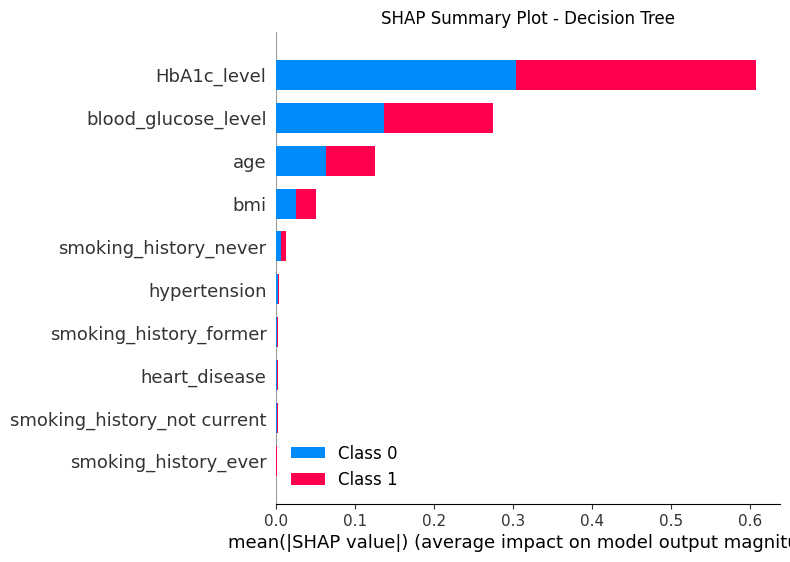

In [ ]:
generate_shap_summary_plot(dt_classifier, 'Decision Tree', X_test)

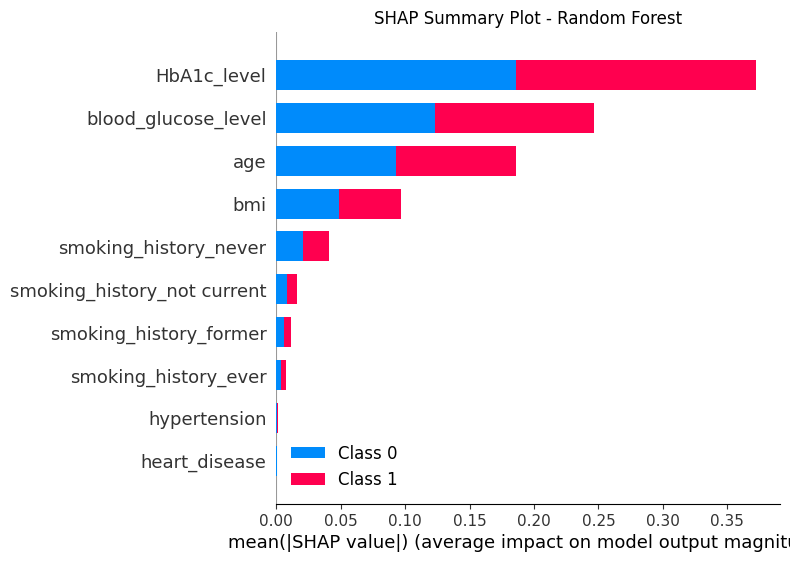

In [ ]:
generate_shap_summary_plot(rf_classifier, 'Random Forest', X_test)

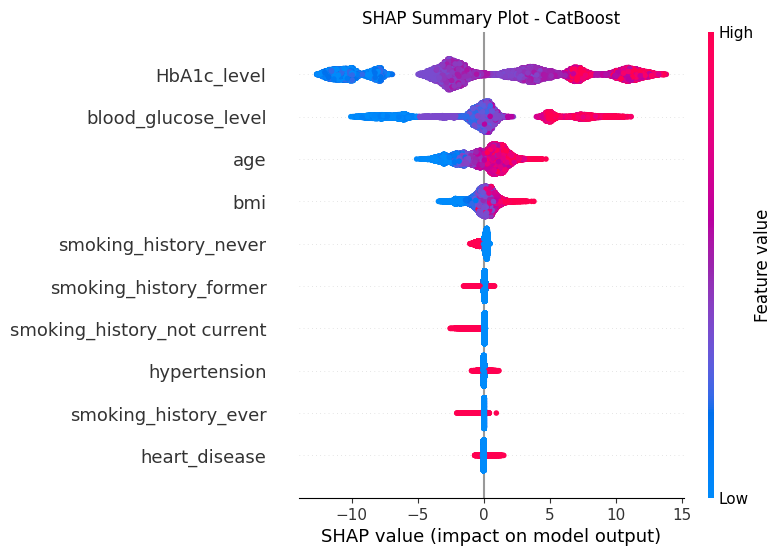

In [ ]:
generate_shap_summary_plot(catboost_classifier, 'CatBoost', X_test)

In [ ]:
generate_shap_summary_plot(xgb, 'XGBoost', X_test)

In [ ]:
generate_shap_summary_plot(svm_model, 'SVM', X_test)

In [ ]:
generate_shap_summary_plot(ada_classifier, 'AdaBoost', X_test)

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Gradient Boost classifier

In [ ]:
# Create the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42, verbose=0, learning_rate=0.1,subsample=0.8)

gb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = gb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Gradient Boosting Model Accuracy:", accuracy)
print("Classification Report:\n", report)

Gradient Boosting Model Accuracy: 0.9639912848898834
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     16917
           1       0.98      0.95      0.96     17047

    accuracy                           0.96     33964
   macro avg       0.96      0.96      0.96     33964
weighted avg       0.96      0.96      0.96     33964



Logistic regression

In [ ]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
logistic_predictions = logistic_model.predict(X_test)

# Calculate AUC
logistic_auc = roc_auc_score(y_test, logistic_predictions)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, logistic_predictions)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logistic_predictions))

Logistic Regression Accuracy: 0.90
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     16984
           1       0.90      0.90      0.90     16948

    accuracy                           0.90     33932
   macro avg       0.90      0.90      0.90     33932
weighted avg       0.90      0.90      0.90     33932



KNN

In [ ]:
# Create a pipeline with the KNN classifier
knn_pipeline = make_pipeline(KNeighborsClassifier())

# Define the parameter grid for GridSearchCV
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],  # You can add more values to test
    'kneighborsclassifier__weights': ['uniform', 'distance'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train,y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Predict on the test set using the best estimator
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)

Best Parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Model Accuracy: 0.943828834138866
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94     16984
           1       0.92      0.98      0.95     16948

    accuracy                           0.94     33932
   macro avg       0.95      0.94      0.94     33932
weighted avg       0.95      0.94      0.94     33932



 in the context of Support Vector Machines (SVM), especially in linear SVM, the decision boundary is also referred to as the hyperplane. The hyperplane is a fundamental concept in SVM that separates the data points of different class.

 Support Vector Machines (SVM), the decision boundary is often associated with the margin. The margin is the separation between the decision boundary and the nearest data point of any class. The SVM algorithm aims to find the decision boundary that maximizes this margin.

K(x
i
​
 ,x
j
​
 )=exp(
∣∣x
i
​
 −x
j
​
 ∣∣
2
 /−
2σ
2
​
 )

 Here,

x
i
​  and x
j
  are data points,
∣∣x
i
​
 −x
j
​
 ∣∣ is the Euclidean distance between them, and

σ is a parameter that controls the width of the kernel.

The C parameter controls the regularization strength, and gamma controls the width of the RBF kernel.

Grid search folows permutation and combination